In [25]:
from data_helper import get_dataloaders_and_standarscaler_photons
from train_helper import train_vae
from plot_helper import plot_training_loss

import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import time
import seaborn as sns

# from sklearn import preprocessing
# from sklearn.decomposition import PCA
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms

In [26]:
# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 512
NUM_EPOCHS = 20
LOGGING_INTERVAL=500
RECONSTRUCTION_TERM_WEIGHT=2.5
SAVE_MODEL_FILE='checkpoint.pth'
path='./DATA/photons.npy'

In [27]:
CUDA_DEVICE_NUM=0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


In [28]:
#ODCZYTANIE DANYCH Z PLIKU 'photons.npy'
photons = np.load(path)
X = np.zeros(photons.shape,dtype=np.float32)
np.copyto(X,photons)

In [29]:
df_data = pd.DataFrame(X, columns = ['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
df_data.head()#zawsze warto rzucić okiem na dane

,X,Y,dX,dY,dZ,E
0,0.42000,1.05666,-5.14814,0.040652,-0.198063,0.979346
1,0.26173,-1.74098,-4.74566,0.052218,-0.303938,0.951260
2,0.39096,1.24705,4.90818,0.019018,0.337769,0.941037
3,0.42000,2.54507,-3.28148,0.098677,-0.127226,0.986953
4,0.42000,1.33431,-4.38559,0.051587,-0.169556,0.984170


In [30]:
train_loader, valid_loader, test_loader, stdcs = get_dataloaders_and_standarscaler_photons(path=path,
    batch_size=BATCH_SIZE, 
    num_workers=0,
    test_fraction=0.2, 
    validation_fraction=0.0)

In [31]:
#TWORZENIE ITERATORA PRZYDATNEGO W PĘTLI UCZĄCEJ MODELU
dataiter_train=iter(train_loader)
data_train=dataiter_train.next()
features_train = data_train

print(features_train.shape)

#TWORZENIE ITERATORA ZBIORU TESTOWEGO 
dataiter_test=iter(test_loader)
data_test=dataiter_test.next()
features_test = data_test


torch.Size([512, 6])


In [32]:
#MODEL NASZEJ SIECI 13->13->7->3
class VAE_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(6, 4),
            #nn.BatchNorm1d(5),
            nn.ReLU(),
            # nn.Linear(5, 4),
            nn.BatchNorm1d(4),
            # nn.ReLU(),
        )

        self.z_mean=nn.Sequential(
            torch.nn.Linear(4,3),
            #nn.BatchNorm1d(3),
            #nn.ReLU(),
            #nn.Linear(3,3)
            )

        self.z_log_var=nn.Sequential(
            torch.nn.Linear(4,3),
           # nn.BatchNorm1d(3),
            #nn.ReLU(),
            #nn.Linear(3,3)
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 4),
            nn.ReLU(),
            nn.BatchNorm1d(4),
            # nn.Linear(4,5),
            # nn.ReLU(),
            #nn.BatchNorm1d(5),
            nn.Linear(4,6)
            
           # nn.Sigmoid()
        )
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())#get_device dziala tylko dla tensoróœ z gpu
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z

    def reparameterize_for_cpu(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to('cpu')#get_device dziala tylko dla tensoróœ z gpu
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize_for_cpu(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [33]:
model = VAE_Linear()
model.to(DEVICE)

#criterion = nn.MSELoss()#FUNKCJA STRATY
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE, 
                             weight_decay=1e-5)

In [34]:
log_dict=train_vae(num_epochs=NUM_EPOCHS, device=DEVICE, model=model,optimizer=optimizer,train_loader=train_loader,loss_fn=None, test_loader=test_loader, logging_interval=LOGGING_INTERVAL, reconstruction_term_weight=RECONSTRUCTION_TERM_WEIGHT, save_model_file=SAVE_MODEL_FILE)

Epoch: 001/020 | Batch 0000/1555 | Loss: 22.5517
Epoch: 001/020 | Batch 0500/1555 | Loss: 16.1565
Epoch: 001/020 | Batch 1000/1555 | Loss: 14.9387
Epoch: 001/020 | Batch 1500/1555 | Loss: 10.3854
***Epoch: 001/020 | Loss: 3.030
Test***Epoch: 001/020 | Loss: 3.000
Time elapsed: 0.33 min
Epoch: 002/020 | Batch 0000/1555 | Loss: 7.6181
Epoch: 002/020 | Batch 0500/1555 | Loss: 7.7565
Epoch: 002/020 | Batch 1000/1555 | Loss: 6.9428
Epoch: 002/020 | Batch 1500/1555 | Loss: 7.4245
***Epoch: 002/020 | Loss: 1.173
Test***Epoch: 002/020 | Loss: 1.164
Time elapsed: 0.64 min
Epoch: 003/020 | Batch 0000/1555 | Loss: 6.3710
Epoch: 003/020 | Batch 0500/1555 | Loss: 6.1422
Epoch: 003/020 | Batch 1000/1555 | Loss: 6.0323
Epoch: 003/020 | Batch 1500/1555 | Loss: 5.6780
***Epoch: 003/020 | Loss: 1.142
Test***Epoch: 003/020 | Loss: 1.135
Time elapsed: 0.93 min
Epoch: 004/020 | Batch 0000/1555 | Loss: 6.1850
Epoch: 004/020 | Batch 0500/1555 | Loss: 6.6069
Epoch: 004/020 | Batch 1000/1555 | Loss: 6.2313
Epo

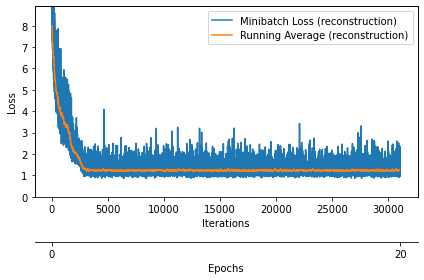

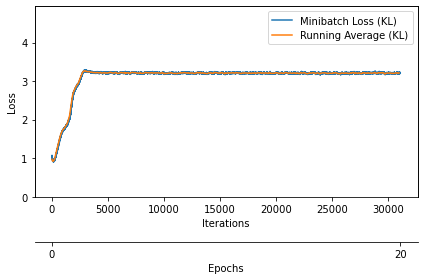

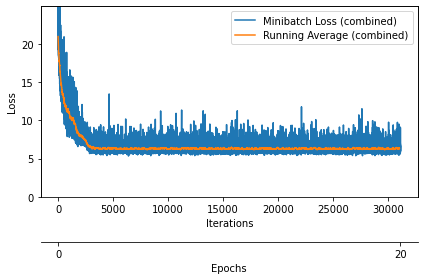

In [35]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()



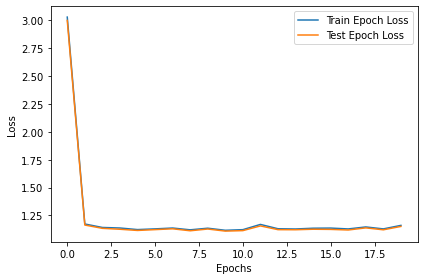

In [36]:
plt.plot(range(len(log_dict['train_combined_loss_per_epoch'])), (log_dict['train_combined_loss_per_epoch']), label='Train Epoch Loss')
plt.plot(range(len(log_dict['test_combined_loss_per_epoch'])), (log_dict['test_combined_loss_per_epoch']), label='Test Epoch Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0.15,0.3)
plt.tight_layout()

In [37]:
tmp=df_data.to_numpy(dtype=np.float32)
orginal=copy.deepcopy(tmp)
tmp=stdcs.transform(tmp)
tmp=torch.from_numpy(tmp)
#print(tmp)
model.eval()
with torch.no_grad():
    result_encoded_features, z_mean, z_log_var, result_decoded_features =model(tmp.to(device=DEVICE))
result=result_decoded_features.cpu().detach().numpy()
result=stdcs.inverse_transform(result)

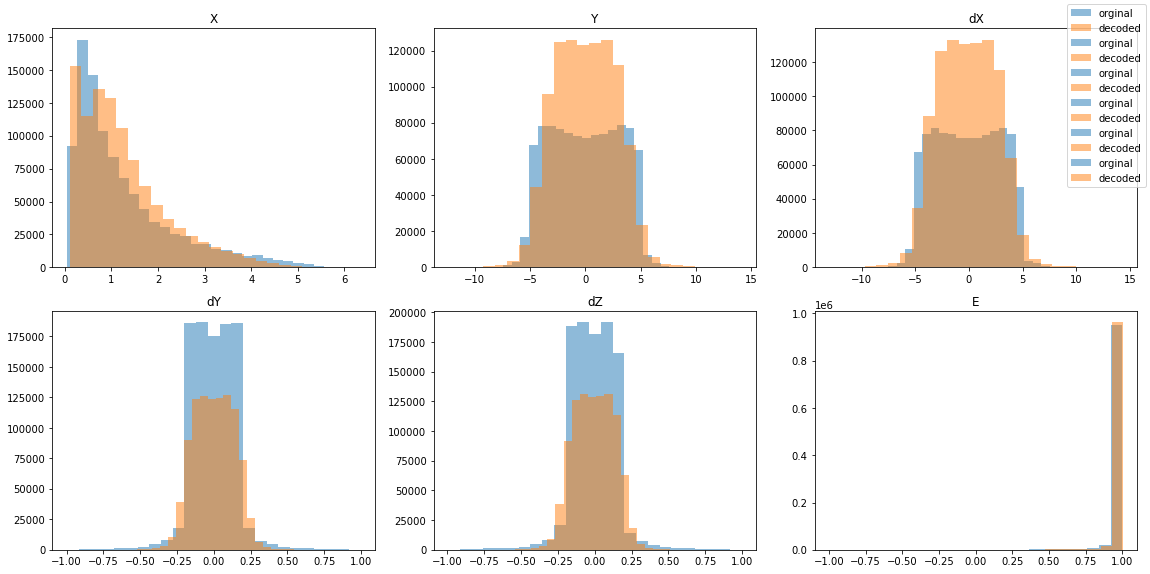

In [38]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16,8)
axs[0, 0].hist(orginal[:,0],bins=25, label ='orginal',alpha=0.5)
axs[0, 0].hist(result[:,0],bins=25, label ='decoded', alpha=0.5)
axs[0, 0].set_title('X')
axs[0, 1].hist(orginal[:,1],bins=25, label ='orginal',alpha=0.5)
axs[0, 1].hist(result[:,1],bins=25, label ='decoded', alpha=0.5)
axs[0, 1].set_title('Y')
axs[0, 2].hist(orginal[:,2],bins=25, label ='orginal',alpha=0.5)
axs[0, 2].hist(result[:,2],bins=25, label ='decoded', alpha=0.5)
axs[0, 2].set_title('dX')
axs[1, 0].hist(orginal[:,3],bins=25, label ='orginal',alpha=0.5)
axs[1, 0].hist(result[:,3],bins=25, label ='decoded', alpha=0.5)
axs[1, 0].set_title('dY')
axs[1, 1].hist(orginal[:,4],bins=25, label ='orginal',alpha=0.5)
axs[1, 1].hist(result[:,4],bins=25, label ='decoded', alpha=0.5)
axs[1, 1].set_title('dZ')
axs[1, 2].hist(orginal[:,5],bins=25, label ='orginal',alpha=0.5)
axs[1, 2].hist(result[:,5],bins=25, label ='decoded', alpha=0.5)
axs[1, 2].set_title('E')
fig.legend()

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()
fig.tight_layout()

In [58]:
decoded_df=pd.DataFrame(result,columns=['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
orginal_df=df_data.iloc[:,:]


concatenated_datasets=pd.concat([orginal_df.assign(dataset_name='orginal'), decoded_df.assign(dataset_name='decoded')],ignore_index=True)
concatenated_datasets.shape
print(concatenated_datasets.index.is_unique)

True


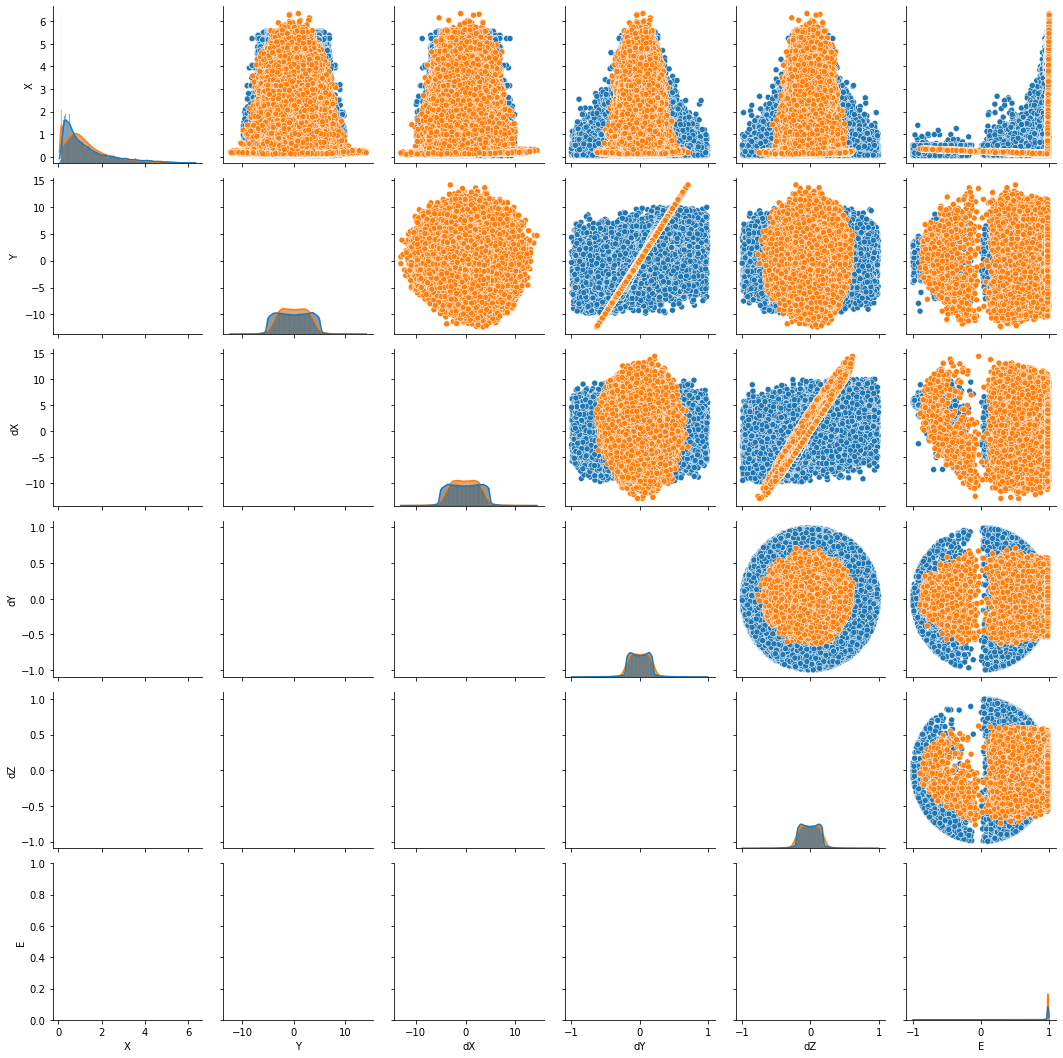

In [59]:
g = sns.PairGrid(concatenated_datasets, hue='dataset_name')
g.map_upper(sns.scatterplot)
#g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

In [60]:
#sns.pairplot(concatenated_datasets, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5),corner=True)


In [61]:
#TODO trzeba by sprawdzić czy to losowanie działa poprawnie i zwraca próbkę reprezentatywną
sample=concatenated_datasets.groupby('dataset_name', group_keys=False).apply(lambda x: x.sample(frac=0.03, random_state=2)) 
print(sample.shape)
print(sample.head())

(59724, 7)
                X         Y        dX        dY        dZ         E  \
1174565  1.727322 -0.357536  3.058385 -0.018887  0.158366  0.984750   
1609424  1.325457  0.309589 -3.021052  0.017282 -0.153036  0.983359   
1539655  0.306336  1.477437  1.428388  0.074109  0.074617  0.979187   
1506954  0.828804  0.922254 -1.377346  0.047394 -0.068961  0.981343   
1855494  1.392571  3.664288 -2.369902  0.186073 -0.119784  0.983679   

        dataset_name  
1174565      decoded  
1609424      decoded  
1539655      decoded  
1506954      decoded  
1855494      decoded  


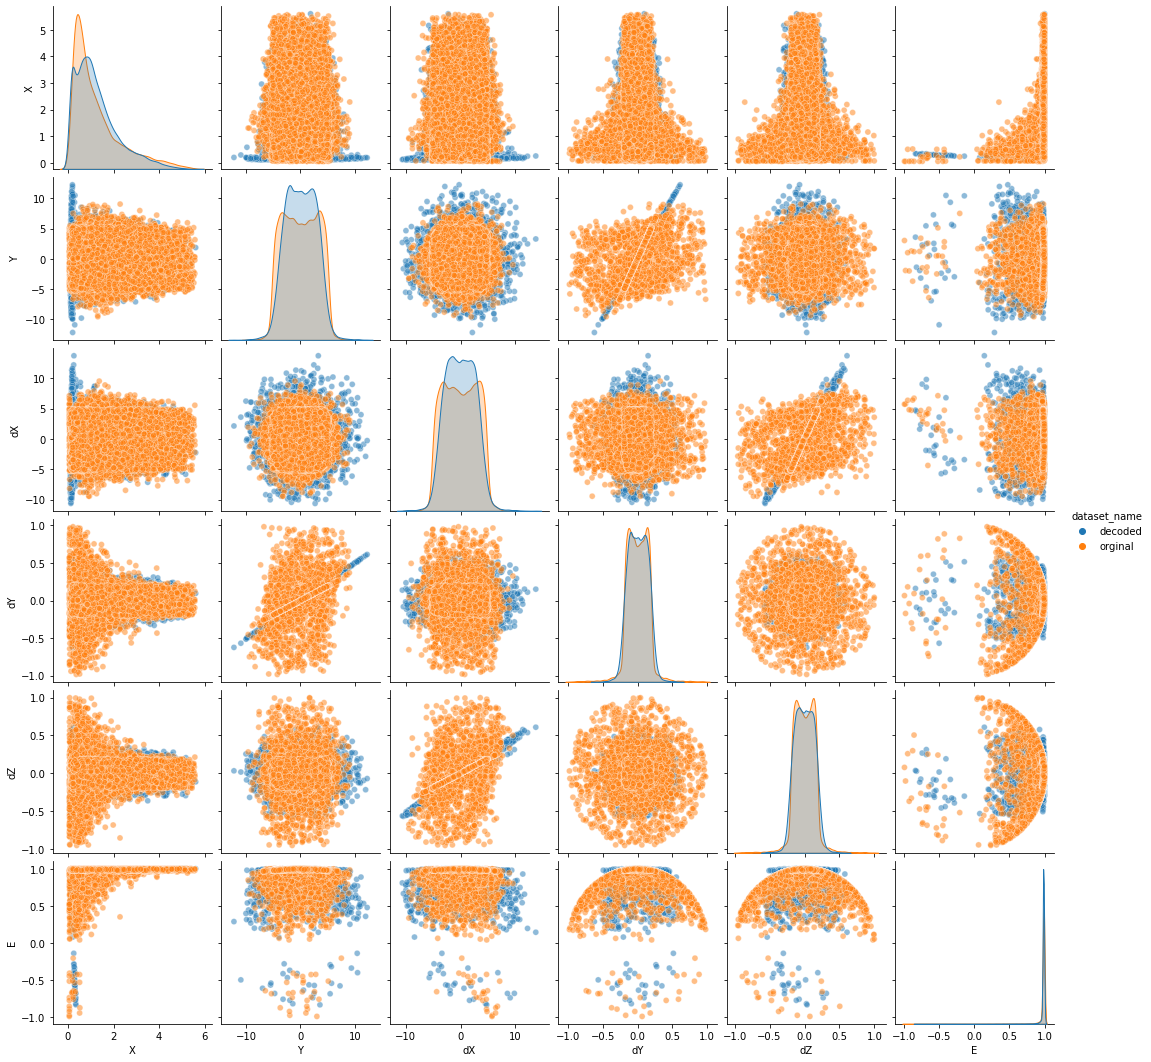

In [62]:
sns.pairplot(sample, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5))

In [63]:
tmp_2=df_data.iloc[37:38,:]
tmp_2=tmp_2.to_numpy(dtype=np.float32)
orginal_2=tmp_2
tmp_2=stdcs.transform(tmp_2)
tmp_2=torch.from_numpy(tmp_2)
model.eval()
with torch.no_grad():
    result_encoded_features_2, z_mean_2, z_log_var_2, result_decoded_features_2=model(tmp_2.to(device=DEVICE))
result_2=result_decoded_features_2.cpu().detach().numpy()
result_2=stdcs.inverse_transform(result_2)

In [64]:
orginal_2=orginal_2.flatten()
result_2=result_2.flatten()

In [65]:
df=pd.DataFrame(np.stack((orginal_2,result_2)), columns=['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
df

,X,Y,dX,dY,dZ,E
0,2.061480,0.760660,-2.516470,0.029714,-0.098330,0.994710
1,2.620407,0.360756,-1.233433,0.019256,-0.061293,0.988457


In [66]:
encoded_features=[]
model.eval()
for index, feature in enumerate(train_loader):
    with torch.no_grad():
        tmp_encoded_features, z_mean, z_log_var, decoded =model(feature.to(device=DEVICE))
        encoded_features.extend(tmp_encoded_features.cpu().detach().numpy())
encoded_features=np.asarray(encoded_features)

print(encoded_features.shape)

(796160, 3)


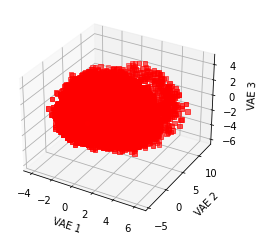

In [67]:
#PRZESTRZEŃ UKRYTA VAE
colors = ['r']
markers = ['s']

fig=plt.figure()
ax=fig.add_subplot(projection='3d')
for c, m in zip(colors, markers):
    ax.scatter(encoded_features[:,0],encoded_features[:,1],encoded_features[:,2],marker=m,c=c)

ax.set_xlabel('VAE 1')
ax.set_ylabel('VAE 2')
ax.set_zlabel('VAE 3')

plt.show()